## Optimizing Classification Models Using Hyperparameter Tuning

This study examines how tree-based classification models can be systematically optimized through hyperparameter tuning to achieve better predictive performance and generalization.

The objective is to predict whether an individual earns more than 50,000 USD per year using census demographic and employment-related features. The workflow spans data preprocessing, exploratory data analysis (EDA), model development, hyperparameter optimization, and performance evaluation, ensuring a well-structured and reproducible machine learning pipeline.

Decision Tree and Random Forest classifiers are employed due to their effectiveness on structured tabular data and their ability to balance interpretability with predictive accuracy.


In [53]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Dataset Loading

The dataset consists of census-based demographic and employment attributes.
These variables provide socio-economic information commonly used in income classification problems.


In [54]:
df = pd.read_csv("adult.csv")
df.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Dataset Overview

Before building models, it is essential to understand the structure and composition of the data.
This includes reviewing feature types, value ranges, and overall dataset characteristics.


In [55]:
df.shape

(32561, 15)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [57]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Missing Value Handling and Data Cleaning

The dataset contains missing values represented using the `'?'` symbol instead of standard null values.
These placeholders are first converted to `NaN` to enable proper detection and handling of missing data.

After identifying missing values, rows containing incomplete information are removed to ensure data consistency and reliability during model training.


In [58]:
# Clean column names
df.columns = df.columns.str.strip()

# Replace '?' placeholders with NaN
df.replace("?", np.nan, inplace=True)

# Check the number of missing values
df.isnull().sum()


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [59]:
df.dropna(inplace=True)
df.shape


(30162, 15)

## Exploratory Data Analysis (EDA)

Exploratory analysis is performed to understand class distribution and key feature relationships.
Visual insights from this step help guide modeling and tuning decisions.


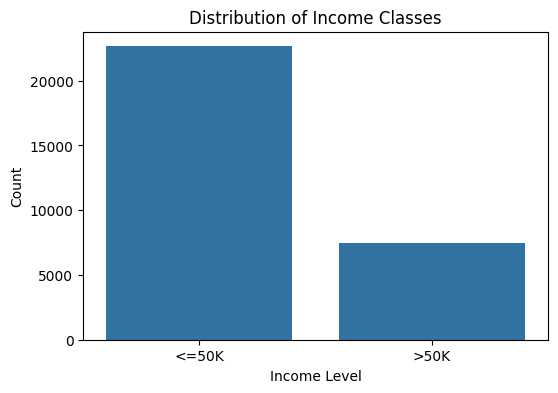

In [60]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="income", data=df)
plt.title("Distribution of Income Classes")
plt.xlabel("Income Level")
plt.ylabel("Count")
plt.show()


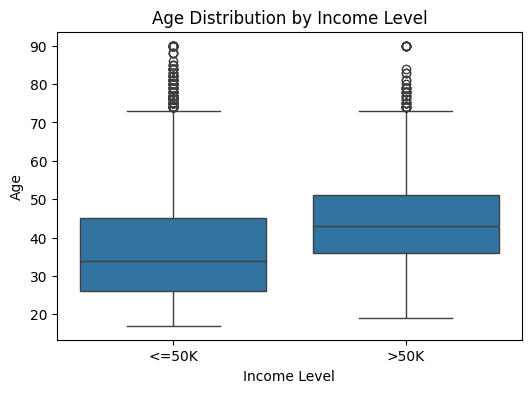

In [61]:
# Age vs income
plt.figure(figsize=(6,4))
sns.boxplot(x="income", y="age", data=df)
plt.title("Age Distribution by Income Level")
plt.xlabel("Income Level")
plt.ylabel("Age")
plt.show()


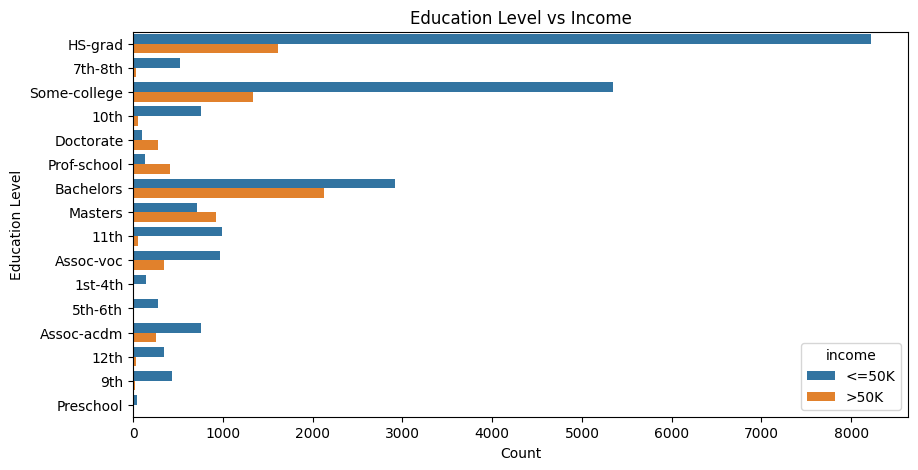

In [62]:
# Education level vs income
plt.figure(figsize=(10,5))
sns.countplot(y="education", hue="income", data=df)
plt.title("Education Level vs Income")
plt.xlabel("Count")
plt.ylabel("Education Level")
plt.show()


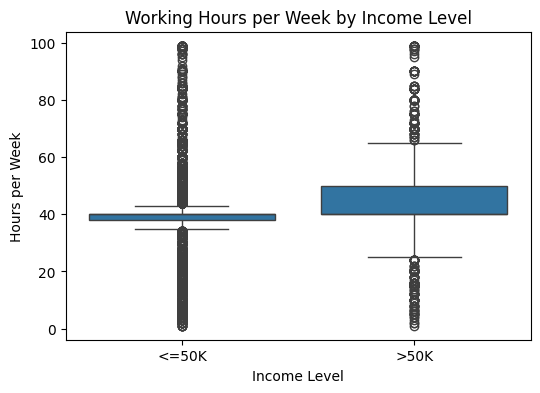

In [63]:
# Working hours vs income
plt.figure(figsize=(6,4))
sns.boxplot(x="income", y="hours.per.week", data=df)
plt.title("Working Hours per Week by Income Level")
plt.xlabel("Income Level")
plt.ylabel("Hours per Week")
plt.show()


## Feature Identification

Categorical and numerical features are identified to guide encoding and model development.


In [64]:
categorical_cols = df.select_dtypes(include="object").columns
numerical_cols = df.select_dtypes(exclude="object").columns

categorical_cols, numerical_cols


(Index(['workclass', 'education', 'marital.status', 'occupation',
        'relationship', 'race', 'sex', 'native.country', 'income'],
       dtype='object'),
 Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
        'hours.per.week'],
       dtype='object'))

## Data Preprocessing

Categorical variables are transformed into numerical representations.
This prepares the dataset for machine learning algorithms that require numeric input.


In [65]:
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop("income_>50K", axis=1)
y = df_encoded["income_>50K"]


## Train-Test Split

The data is divided into training and testing sets.
This allows objective evaluation of model performance on unseen data.


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Decision Tree Classifier

A Decision Tree classifier is trained as a baseline model.
Its simplicity and interpretability make it a useful reference for comparison.


In [67]:
# Decision Tree training and evaluation
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))


Decision Tree Accuracy: 0.8022542681916128
              precision    recall  f1-score   support

       False       0.87      0.86      0.87      4533
        True       0.60      0.63      0.61      1500

    accuracy                           0.80      6033
   macro avg       0.74      0.74      0.74      6033
weighted avg       0.81      0.80      0.80      6033



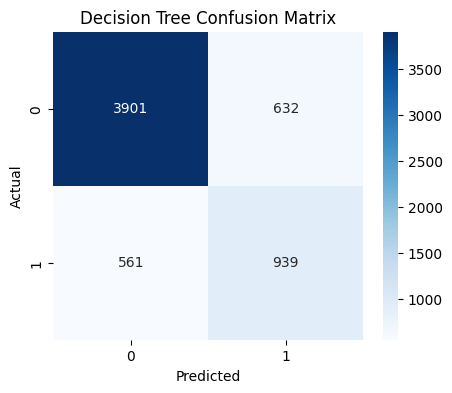

In [68]:
# Confusion matrix - Decision Tree
cm_dt = confusion_matrix(y_test, dt_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Random Forest Classifier

Random Forest is an ensemble method that aggregates multiple decision trees.
This approach reduces overfitting and generally improves predictive performance.


In [69]:
# Random Forest training and evaluation
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.8417039615448367
              precision    recall  f1-score   support

       False       0.88      0.92      0.90      4533
        True       0.71      0.61      0.66      1500

    accuracy                           0.84      6033
   macro avg       0.80      0.76      0.78      6033
weighted avg       0.84      0.84      0.84      6033



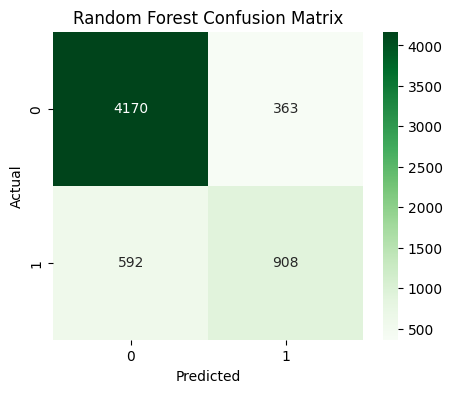

In [70]:
# Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Feature Importance Analysis

Feature importance highlights the variables that contribute most to predictions.
This improves model interpretability and trust in the results.


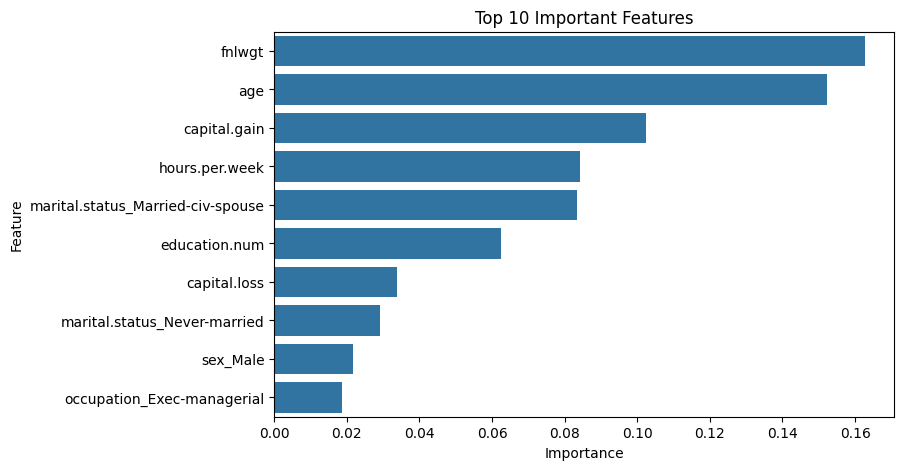

In [71]:
# Feature importance from Random Forest
importances = rf_model.feature_importances_
features = X.columns

fi_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Top 10 Important Features")
plt.show()


## Hyperparameter Tuning

Hyperparameter tuning is applied to further improve model performance.
RandomizedSearchCV is used to efficiently explore the parameter space while controlling runtime.


In [72]:
# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    random_state=42
)

rf_search.fit(X_train, y_train)
rf_search.best_params_
rf_search.best_score_


np.float64(0.8600024866343404)

In [73]:
# Tuned Random Forest evaluation
best_rf = rf_search.best_estimator_
tuned_pred = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, tuned_pred))
print(classification_report(y_test, tuned_pred))


Tuned Random Forest Accuracy: 0.854135587601525
              precision    recall  f1-score   support

       False       0.88      0.94      0.91      4533
        True       0.76      0.60      0.67      1500

    accuracy                           0.85      6033
   macro avg       0.82      0.77      0.79      6033
weighted avg       0.85      0.85      0.85      6033



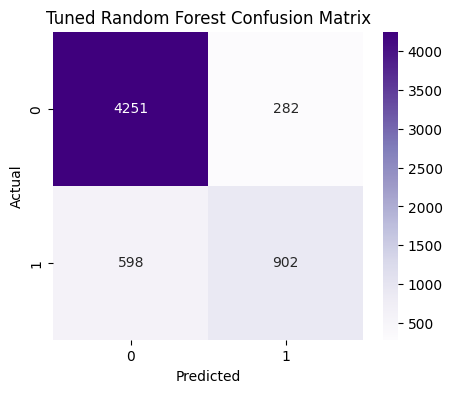

In [74]:
# Confusion matrix - Tuned Random Forest
cm_tuned = confusion_matrix(y_test, tuned_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Purples")
plt.title("Tuned Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Performance Comparison

Comparing baseline and tuned models highlights the impact of optimization.
This step helps justify the final model selection.


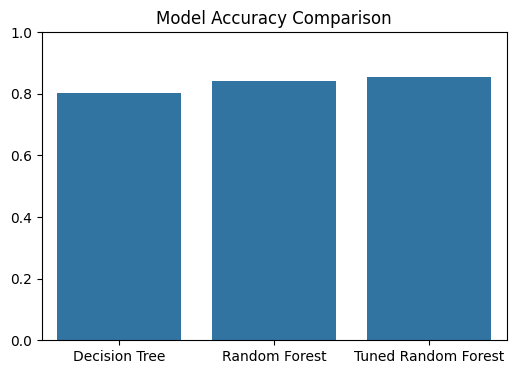

In [75]:
# Model accuracy comparison
models = ["Decision Tree", "Random Forest", "Tuned Random Forest"]
accuracies = [
    accuracy_score(y_test, dt_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, tuned_pred)
]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


## Conclusion

This work demonstrated a complete machine learning pipeline for income prediction.
Hyperparameter tuning significantly improved model accuracy and generalization.
The tuned Random Forest model emerged as the most effective solution for this task.
